## Simulate non-cyanogenic evolution via drift alone

There is a finding that across a cline from less to more urban the frequency of a non-cyanogenic phenotype increases
The phenotype is genetically controlled by two loci, both of which have a segregating knock-out allele
If any individual is homozygous for either knockout they become non-cyanogenic

In this extremely simple simulation I create a 'population' which is represented by 2 lists of alleles (A/a and B/b)
To simulate evolution I randomly sample with replacement from the lists to create new list that represent the next generation.

By repeating this process with variable starting frequencies, population sizes and numbers of generations (functionally equivalent to steps in a strict stepping stone) we can look at the change in the frequency of cyanogenic and non-cyanogenic phenotypes

## Extension to previous simulations — Spatial structure

To build off of the previous single-population stepping stone model, I have added a few functions that allow us to add spatial structure to our simulations, effectively simulating the trajectory of multiple populations simultaneously. Once migration is added, this will be analogous to a metapopulation.

#### Major changes to script

1. Since there will be multiple populations, they are now stored as entries in a dictionary. Each key in the dictionarry corresponds to a population and the value is a list containing the frequencies of alleles phenotype, updated each generation. 
2. The alleles that correspond to each population are stored in a separate dictionary with keys matching those from the population dictionary. As such, allele frequencies for populations are calculated by sampling the allele lists in the 'alleles' dictionary with the key matching the population.
3. Every generation, each population has some probability (p) of generating a new population with N alleles sampled from the population that created it. This is not the most realistic scenario but can easily be modified later. 
4. Simulations are now stored separately in a dictionary called 'sim' where each key corresponds to a simulation. 
5. These changes allow us to model clines in two ways:
    - Clines across 'time': looking at phenotype frequencies **within** populations
    - Clines across 'space': looking at phenotype frequencies **across** created populations

## Extension to previous simulations — Logistic population growth

To build off of the simulations that included spatial structure, I have incorporated logistic population growth into the simulations. 

**Major changes to script**

1. Newly created populations form as a bottleneck from the population that created it. The proportion of alleles sampled is some fraction (bot) multiplied by the population size of the source population. 
2. Every generation, every population grows in size according to an approximate logistic growth curve. The logistic growth function incorporates a fractional constant that, when multiplied by the current population size, modifies the per capita growth rate of the population. The carrying capacity is thus altered by changing this fractional constant. 
3. The size of every population is stored as an integer in a list within the alleles dictionary under the key corresponding to the population. This integer is called as needed by the functions that require population size as an argument (e.g. 'bottle', 'pop_growth').

## Extension to previous simulations — Migration

To simulations that previously included spatial structure and logistic population growth, I have added migration

**Major changes to script**

1. Every generation, every population exchanges alleles with every other population at a rate that declines with the distance between them. Migration rate declines linearly with distance and is determined by the 'migration_rate' function. 
2. Distances between populations are calculated as the difference between the lengths of the population ID's (keys in alleles and pops dictionaries) since these track population history. As such, a larger difference = greater distance = lower migration rate. 
3. Distances and migration rates are stored in a dictionary ('Dis'), which is re-created at the start of every generation since more populations may have been generated. The key's in this dictionary are concatenated strings formed from the union of all pairwise combinations of existing populations. This makes it easy to determine the correct migration rate between all pairs of populations.


## Extension to previous simulations — Explicit spatial structure

To previous simulations, I have made spatial structure among populations explicit.

**Major changes to script**

1. Simulations are now initialized by generating an m x n dimensional matrix with 1 unit between adjacent cells on x and y axes. Distances along diagonals are calculated using pythagorean theorem. All distances and migration rates are calculated before simulations are run and are stored in the 'Disntance_Dic' dictionary (global)
2. The first population is randomly placed within the array. New populations can only be created in adjacent cells.
3. Populations are named sequentially based on order of creation (i.e. 1, 2, 3, etc.). Naming in matrix corresponds to naming in dictionaries containing population information (i.e. allele frequencies) and allele lists.

## Extension to previous simulations — Probabilistic migration

To previous simulations, I have implimented an infinite allele pool model to make simulations more in line with population genetic theory. 

**Major changes to script**

1. For migration, rather than creating a separate list of alleles formed from the concatenation of alleles sampled from the focal population and all other source populations, the probability of each alleles is now calculated based on the weighted mean migration rate and weighted mean allele frequencies in source populations. Weighting is done by population size. 
2. Formula for migration: pA1 = pA0(1 - m) + pAm(m), where pA0 is the current frequency of allele 'A' in the focal population, pAm is the weighted mean allele frequency across all source populations in the metapopulation and 'm' is the weighted mean migration rate across the metapopulation.
3. The probability of creating a new population now increases with increasing population size. 

In [2]:
# Modules used throughout script
import random
from collections import OrderedDict
import csv
import time
from datetime import datetime
import os
import itertools
import math
import numpy as np
import pandas as pd
from numpy.random import choice

# Randomly sample 'N' alleles from lists containing alleles for locus A 
def sample_population_A(locus_A, N):
    '''
    ## PARAMETERS ##
    
    locus_A: List containing alleles 'a' and 'A'
    
    N: Number of alleles to sample from locus_A (i.e. population size)
    
    ## USED IN FUNCTIONS ##
    
    1. migrate_A
    2. migrate_B
    3. create_population_2
    4. cline
    '''  
    new_locus_A = [random.choice(locus_A) for _ in range(N)]
    return new_locus_A

# Randomly sample 'N' alleles from lists containing alleles for locus B
def sample_population_B(locus_B, N):
    '''
    ## PARAMETERS ##
    
    locus_B: List containing alleles 'b' and 'B'
    
    N: Number of alleles to sample from locus_B (i.e. population size)
    
    ## USED IN FUNCTIONS ##
    
    1. migrate_A
    2. migrate_B
    3. create_population_2
    4. cline
    '''  
    new_locus_B = [random.choice(locus_B) for _ in range(N)]
    return new_locus_B

# Function used to determine migration rates based on distances between all populations. 
# Linear decrease in migration rate with increasing distance. Rate of decreased based on slope ('m')
# which depends on the maximum distance between populations and the desired 'y_int' (i.e. migration rate when distace = 0)
def migration_rate(Distance_Dic, y_int):
    '''
    ## PARAMETERS ##
    
    Distance_Dic: Dictionary containing distances between all pairwise combinations of cells in 'Matrix'. 
    Will also contain migration rates after use of this function
    
    y_int: Desired migration rate when distance = 0
        
    ## USED IN FUNCTIONS ##
    
    1. Distance_Mig
    '''  
    max_dis = max(Distance_Dic.values()) # Max distance between populations
    m = (y_int - 0)/(max_dis[0] - 0) # Slope. Assumes close to no migration at max distance. Relized migration at max distance may be slightly greater than 0 due to rounding. 
    for Dkey, Dvalue in Distance_Dic.items():
        Mig_prop = y_int - m*Dvalue[0] 
        Distance_Dic[Dkey].append(round(Mig_prop,2)) # Append migration rate to 'Distance_Dic' dictionary
        
# Function to calculate distances between all pairwise combinations of cells in matrix. Also calls
# the migration rate between populations and appends this to the distance dictionary. 
def Distance_Mig(Matrix, y_int):
    '''
    ## PARAMETERS ##
    
    Matrix: m x n dimensional matrix, initialized at the outset of each simulation. 
    Contains empty cells that may become filled with populations. 
    
    y_int: Desired migration rate when distance = 0
        
    ## USED IN FUNCTIONS ##
    
    1. Simulate
    ''' 
    rows = [i for i in range(len(Matrix))] 
    cols = [i for i in range(len(Matrix))]
    matelem = [(i,j) for i in rows for j in cols]
    dis = [[i,j] for i in matelem for j in matelem]
    for i in dis:
        if i[0][0] == i[1][0]: # Within rows
            dis1 = abs(i[1][1] - i[0][1])
            i.append(dis1)
        elif i[0][1] == i[1][1]: # Within columns
            dis2 = abs(i[1][0] - i[0][0])
            i.append(dis2)    
        else: # Diagonals
            dis3 = (((i[1][1] - i[0][1])**2) + ((i[1][0] - i[0][0])**2))**(0.5)
            i.append(dis3)
    global Distance_Dic
    Distance_Dic = {'{0}.{1}'.format(key1,key2):[round(key3,2)] for key1,key2,key3 in dis}
    migration_rate(Distance_Dic, y_int)

# Function used to sample alleles based on infinite allele pool model. Allele 'A'.     
def sample_alleles_A(pA1, Akey, Avalue, alleles, r, K):
    '''
    ## PARAMETERS ##
    
    pA1: Probability of sampling allele 'A'. Returned by 'alleles_next_gen()' 
    
    Akey: Index used to cycle through keys in alleles dictionary. 
    Note keys correspond to populations. See 'cline' function.  
    
    Avalue: Index used to cycle through values in alleles dictionary. See 'cline function.
    
    alleles: Dictionary used to stored lists of alleles population size for each population. 
    Updated every generation.
    
    r: Maximum per capita population growth rate
    
    K: Carrying capacity (i.e. maximum sustainable population size)
        
    ## USED IN FUNCTIONS ##
    
    1. alleles_next_gen
    ''' 
    list_of_candidates = ['A','a'] # Possible alleles to sample
    number_of_items_to_pick = pop_growth(r, Akey, Avalue, K) # Number to sample. Corresponds to next generation's size.
    probability_distribution= [pA1, (1 - pA1)] # Sampling probabilities. Returned by 'alleles_next_gen'
    draw = choice(list_of_candidates, number_of_items_to_pick, p=probability_distribution) # Sample alleles
    return list(draw) # Return list of newly sampled alleles. Becomes allele pool in the next generation 

# Same as above but for allele 'B'
def sample_alleles_B(pB1, Akey, Avalue, alleles, r, K):
    list_of_candidates = ['B','b']
    number_of_items_to_pick = pop_growth(r, Akey, Avalue, K)
    probability_distribution= [pB1, (1 - pB1)]
    draw = choice(list_of_candidates, number_of_items_to_pick, p=probability_distribution)
    return list(draw)

def alleles_next_gen(Akey, pop_list, alleles, Matrix):
    '''
    ## PARAMETERS ##
        
    Akey: Index used to cycle through keys in alleles dictionary. 
    Note keys correspond to populations. See 'cline' function.  
    
    pop_list: list containing all current populations in existence
    
    alleles: Dictionary used to stored lists of alleles population size for each population. 
    Updated every generation.
    
    Matrix: m x n dimensional matrix, initialized at the outset of each simulation. 
    Contains empty cells that may become filled with populations.
        
    ## USED IN FUNCTIONS ##
    
    1. cline
    ''' 
    to_pop = (np.where(Matrix == int(Akey))[0][0], np.where(Matrix == int(Akey))[1][0]) # Location of focal population in matrix. 
    migration_weighted = [] # List holding migration rates
    allele_weighted_A = [] # List holding frequency of 'A' alleles
    allele_weighted_B = [] # List holding frequency of 'B' alleles
    Size = [] # List holding population sizes
    for i in pop_list: 
        if Akey == i: 
            pass
        else:
            from_pop = (np.where(Matrix == int(i))[0][0], np.where(Matrix == int(i))[1][0]) # Location of source population in matrix
            con = str(to_pop) + '.' + str(from_pop) # Create concatenated string from current focal population and source population                
            migration_weighted.append(Distance_Dic[con][1]) # Append migration rate to list
            allele_weighted_A.append(allele_freq(alleles[i]['A'])) # Append alleles 'A' frequency to list
            allele_weighted_B.append(allele_freq(alleles[i]['B'])) # Append allele 'B' frequency to list
            Size.append(alleles[i]['S'][0]) # Append population size to list
    migration_weighted = sum(migration_weighted[g] * Size[g] / sum(Size) for g in range(len(migration_weighted))) # Weighted migration rate
    allele_weighted_A = sum(allele_weighted_A[g] * Size[g] / sum(Size) for g in range(len(allele_weighted_A))) # Weighted allele 'A'
    allele_weighted_B = sum(allele_weighted_B[g] * Size[g] / sum(Size) for g in range(len(allele_weighted_B))) # Weighted allele 'B'
    pA1 = ((1 - migration_weighted)*allele_freq(alleles[Akey]['A'])) + (migration_weighted*allele_weighted_A) # Probability of sampling 'A' in next generation
    pB1 = ((1 - migration_weighted)*allele_freq(alleles[Akey]['B'])) + (migration_weighted*allele_weighted_B) # Probability of sampling 'B' in next generation
    return pA1, pB1

# From list containing alleles, calculate the frequency of 'A' or 'B' allele. 
def allele_freq(locus):
    '''
    ## PARAMETERS ##
    
    locus: List containing alleles
    
    ## USED IN FUNCTIONS ##
    
    1. cline
    '''
    p = sum(1*i.isupper() for i in locus)/float(len(locus))
    return p

# Return maximum rate of increase from final pop. size, initial pop size and time
def rate_of_increase(Pf, P0, t):
    return math.log(Pf/P0)/t

# Function for logistic population growth. Takes current population size (from alleles dictionary) 
# as input and return new population size. 
def pop_growth(r, Akey, Avalue, K):
    '''
    ## PARAMETERS ##
    
    r: Maximum per capita population growth rate
    
    Akey: Index used to cycle through keys in alleles dictionary. 
    Note keys correspond to populations. See 'cline' function.  
    
    Avalue: Index used to cycle through values in alleles dictionary. See 'cline function. 
    
    K: Carrying capacity (i.e. maximum sustainable population size)
    
    ## USED IN FUNCTIONS ##
    
    1. cline
    '''
    size = Avalue['S'][0] # Retrieve size of population. 'Akey' allows indexing of alleles dictionary in cline function
    K = float(K)
    new_size = size*K/(size + (K - size)*math.exp(-r)) # Calculates the proportional reduction of population growth rate based on desired carrying capacity ('K'). At 'K', growth rate = 1 = no change
    return [int(round(new_size))]

# Simple bottleneck function. 
def bottle(bot, Akey, Avalue):
    '''
    ## PARAMETERS ##
    
    bot: Desired bottleneck proportion
    
    Akey: Index used to cycle through keys in alleles dictionary. 
    Note keys correspond to populations. See 'cline' function.  
    
    Avalue: Index used to cycle through values in alleles dictionary. See 'cline function. 
    
    ## USED IN FUNCTIONS ##
    
    1. create_population_2
    '''
    return int(math.ceil(bot*Avalue['S'][0]))

# Linear function that takes size of population and returns the probability of creating a new
# population.
def prob_create(K, max_p_create, Akey, Avalue):
    '''
    ## PARAMETERS ##
    
    K: Carrying capacity
    
    max_p_create: maximum probability of creating a new population
    
    Akey: Index used to cycle through keys in alleles dictionary. 
    Note keys correspond to populations. See 'cline' function.  
    
    Avalue: Index used to cycle through values in alleles dictionary. See 'cline function. 
        
    ## USED IN FUNCTIONS ##
    
    1. create_population
    '''  
    m = (max_p_create - 0)/(K - 0) # Slope. Assumes close to no migration at max distance. Relized migration at max distance may be slightly greater than 0 due to rounding. 
    Size = Avalue['S'][0]
    p_create = Size*m
    return float(p_create)

# Create new population as empty list and add to 'pops' dictionary. Also create four lists of alleles
# sampled from pool of alleles from population that generated the new one. Alleles added to 'alleles'
# dictionary. Also adds population to matrix. This function first evaluates whether a population will 
# be created then randomly selects a vacant neighboring cell where population will go. If no cells are
# vacant, the function passes.
def create_population(max_p_create, K, Akey, Avalue, pops, alleles, bot, Matrix): 
    '''
    ## PARAMETERS ##
    
    max_p_create: maximum probability of creating a new population
    
    Akey: Index used to cycle through keys in alleles dictionary. 
    Note keys correspond to populations. See 'cline' function.  
    
    Avalue: Index used to cycle through values in alleles dictionary. See 'cline function. 
    
    pops: Dictionary containing information (e.g. allele frequencies) of each population
    Updated at the end of every generation.
    
    alleles: Dictionary used to stored lists of alleles population size for each population. 
    Updated every generation.
    
    bot: Desired bottleneck proportion. 
    
    Matrix: m x n dimensional matrix, initialized at the outset of each simulation. 
    Contains empty cells that may become filled with populations. 
    
    ## USED IN FUNCTIONS ##
    
    1. cline
    '''
    if not alleles['1']['A']: #If there are no alleles for first population, pass. Only valid for first iteration when the populations have yet to be initialized
    #print 'There are no populations from which to sample!!'
        pass
    else:
        list_of_candidates = ['1','0']
        number_of_items_to_pick = 1
        p_create = prob_create(K, max_p_create, Akey, Avalue)
        probability_distribution= [p_create, (1 - p_create)]
        create = list(choice(list_of_candidates, number_of_items_to_pick, p=probability_distribution))
        if create[0] == '1': #If a '1' is sampled, create population
            x, y = np.where(Matrix == int(Akey))[0][0], np.where(Matrix == int(Akey))[1][0]
            X, Y = (len(Matrix) - 1), (len(Matrix) - 1)
            # Create list containijng all neighboring cells
            Nlist = [(x2, y2) for x2 in range(x-1, x+2)
                for y2 in range(y-1, y+2)
                    if (-1 < x <= X and
                    -1 < y <= Y and
                    (x != x2 or y != y2) and
                    (0 <= x2 <= X) and
                    (0 <= y2 <= Y))]
            # Reduced list containing only neighboring cells that lack a population
            Nlist_red = []
            for item in Nlist:
                i, j = item[0], item[1]
                if Matrix[i, j] == 0:
                    Nlist_red.append(item)
            # If all neighboring cells are occupied, pass
            if not Nlist_red:
                pass
            else:
            # Otherwise, select and empty neighboring cell at random and place new population
                Nsam = random.randint(0, len(Nlist_red) - 1)
                i, j = Nlist_red[Nsam][0], Nlist_red[Nsam][1] 
                global pop_counter #global variable that tracks the number of populations created
                pop_counter += 1 #Increment 'pop_counter' by 1 if population is being created. 
                #Add two lists to 'alleles' dictionary ('A' and 'B'). Naming: 'Pop.number' 
                alleles['{0}'.format(pop_counter)] = {'A':sample_population_A(Avalue['A'], bottle(bot, Akey, Avalue)),'B':sample_population_B(Avalue['B'], bottle(bot, Akey, Avalue)), 'S':[bottle(bot, Akey, Avalue)]}
                pops['{0}'.format(pop_counter)] = [] #Empty list for new population. Naming same as alleles.
                Matrix[i, j] = pop_counter
        else:
            pass
        
# Given the frequencies of 'A' and 'B' alleles, return the frequency of the 'acyanogenic' phenotype (i.e. recessive
# at either the A locus, B locus, or both) 
def phenotype(pA, pB):
    '''
    ## PARAMETERS ##
    
    pA: Frequency of 'A' allele
    
    pB: Frequency of 'B' allele
    
    ## USED IN FUNCTIONS ##
    
    1. cline
    '''
    qA = 1-pA
    qB = 1-pB
    mut= qA**2 + qB**2 - (qA**2 * qB**2)
    WT = 1-mut
    return mut # Frequency of acyanogenic phenotype

# Cline function. Every generation, alleles are exchanged among populations. Populations follow
# logistic population growth. Ever generation, every population has some probability (p) of generating a new population, with alleles
# sampled from the population that created it.
def cline(locus_A, locus_B, steps, N, max_p_create, pops, alleles, bot, Matrix, K, r):
    '''
    ## PARAMETERS ##
    
    locus_A: List containing alleles 'a' and 'A'
    
    locus_B: List containing alleles 'b' and 'B'
    
    steps: Number of generations  
    
    N: Number of alleles to sample (i.e. population size). In this case, starting population size.
    
    p: Desired probability of creating a new population
    
    pops: Dictionary containing information (e.g. allele frequencies) of each population
    Updated at the end of every generation.
    
    alleles: Dictionary used to stored lists of alleles population size for each population. 
    Updated every generation.
    
    bot: Desired bottleneck proportion. 
    
    Matrix: m x n dimensional matrix, initialized at the outset of each simulation. 
    Contains empty cells that may become filled with populations. 
    
    K: Desired carrying capacity. 
    
    ## USED IN FUNCTIONS ##
    
    1. simulate
    '''
    for i in range(steps):
        pop_list = pops.keys()
        for Akey, Avalue in alleles.items():
            if Akey in pops.keys():
                if 'A' and 'B' in Avalue.keys():
                    if not Avalue['A'] and not Avalue['B']: 
                        #If allele lists are empty, sample from list of initial allele frequencies. Only used for first generation
                        Avalue['S'] = [N]
                        Avalue['A'] = (sample_population_A(locus_A, N))
                        Avalue['B'] = (sample_population_B(locus_B, N))
                    else:
                        #If allele lists are not empty, sample from previously sampled set of alleles. 
                        Avalue['S'] = pop_growth(r, Akey, Avalue, K)
                        Avalue['A'] = sample_alleles_A(alleles_next_gen(Akey, pop_list, alleles, Matrix)[0], Akey, Avalue, alleles, r, K)
                        Avalue['B'] = sample_alleles_B(alleles_next_gen(Akey, pop_list, alleles, Matrix)[1], Akey, Avalue, alleles, r, K)      
                create_population(max_p_create, K, Akey, Avalue, pops, alleles, bot, Matrix) #Create population. Alleles will be sampled (see above). Population is currently empty list
        for Akey, Avalue in alleles.items():
            #Calculate allele and phenotype frequencies for every population, including newly created ones. 
            pA = allele_freq(Avalue['A']) 
            pB = allele_freq(Avalue['B'])
            pops[Akey].append([np.where(Matrix == int(Akey))[0][0], np.where(Matrix == int(Akey))[1][0], Avalue['S'][0], i, pA, pB, phenotype(pA, pB)])
    return Matrix, pops

        
# Using the functions defined above, 'simulate' performs 'sims' iterations of the cline function -- simulating 
# the combined effects of drift and migration in a spatially explicit framework  -- each time storing the results.
def simulate(pA, pB, steps, N, sims, y_int, K, bot, max_p_create, r, x_mat, y_mat):
    '''
    ## PARAMETERS ##
    
    pA: Initial frequency of 'A' alleles.
    
    pB: Initial frequency of 'B' alleles.
    
    steps: Number of generations  
    
    N: Number of alleles to sample (i.e. population size). In this case, starting population size.
    
    sims: Number of iterations. 
    '''
    qA = 1-pA # Frequency of 'a' allele
    qB = 1-pB
    r = float(r)
    max_p_create = float(max_p_create)
    # Make the two lists based on the allele frequency to represent the initial population
    locus_A = (['A'] * int(N*pA) ) + (['a'] * int(round(N*qA)) ) # [A,A,A,A,a,a,a,a,....]
    locus_B = (['B'] * int(N*pB) ) + (['b'] * int(round(N*qB)) ) 
    ####### sims simulations #####################
    # We will simulate 'steps' iterations of resampling this population to simulate drift
    # We will then repeat that simulation of 'steps' iterations 1000 times to get a mean
    ##############################################
    for s in range(sims):
        pops = OrderedDict({'1':[]}) # Re-initialize dictionary to store populations
        alleles = OrderedDict({'1':{'A':[],'B':[],'S':[N]}}) # Re-initialize dictionary to store allele lists
        Matrix = np.zeros((x_mat,y_mat), dtype = 'int')
        Distance_Mig(Matrix, y_int)
        Matrix[0,0] = 1
        global pop_counter # Reset population counter
        pop_counter = 1
        # reset the population for each iteration. I don't actually think this is necessary
        locus_A = (['A'] * int(N*pA) ) + (['a'] * int(round(N*qA)) )  # Re-initialize initial allele lists.
        locus_B = (['B'] * int(N*pB) ) + (['b'] * int(round(N*qB)) ) 
        cline(locus_A,locus_B, steps, N, max_p_create, pops, alleles, bot, Matrix, K, r) # Run cline function
        global sim
        sim[s] = pops # Append results to global 'sim' dictionary
        


In [6]:
start_time = time.time()
datestring = datetime.strftime(datetime.now(), '%Y%m%d')

pop_counter = 1
sim = {}
simulate(pA=0.5, pB=0.5, steps=15, N=100, sims=2, y_int=0.3, K=100, bot=0.1, max_p_create=1.0, r=rate_of_increase(1.5,1,1), x_mat=10, y_mat=10)
#simulate(pA=0.5, pB=0.5, steps=5, N=10, sims=2, y_int=0.15, K=100, bot=0.1, max_p_create=1.0, r=2.0, x_mat=10, y_mat=10)
sim

print "My program took", time.time() - start_time, "seconds to run"

My program took 0.53546500206 seconds to run


In [11]:
path = os.getcwd()
path

'/Users/jamessantangelo/Documents/Academia/Doctorate (PhD)/Projects/SEC - Simulating evolutionary clines/SEC_Python Scripts/7. Probabilistic migration'

In [12]:
DataFrame = []
Colnames = ["Sim","x","y","Population","Pop_size","Generation","pA","pB","Acyan"]
for i in sim.keys():
    for j, x in sim[i].items():
        for z in x:
            DataFrame.append([i, z[0], z[1], j, z[2], z[3], z[4], z[5], z[6]])
Test = pd.DataFrame(DataFrame, columns = Colnames)
os.chdir(path)
Test.to_csv(datestring+"_SEC_Drift_Nvary.results.csv")

      

In [5]:
sim

{0: OrderedDict([('1',
               [[0, 0, 100, 0, 0.47, 0.43, 0.51453559],
                [0, 0, 100, 1, 0.4, 0.34, 0.6387839999999999],
                [0, 0, 100, 2, 0.45, 0.4, 0.5536000000000001],
                [0, 0, 100, 3, 0.51, 0.3, 0.612451],
                [0, 0, 100, 4, 0.49, 0.37, 0.55376631],
                [0, 0, 100, 5, 0.38, 0.41, 0.5986903600000001],
                [0, 0, 100, 6, 0.36, 0.37, 0.64392976],
                [0, 0, 100, 7, 0.3, 0.35, 0.705475],
                [0, 0, 100, 8, 0.31, 0.47, 0.6232635099999999],
                [0, 0, 100, 9, 0.25, 0.44, 0.6997000000000001],
                [0, 0, 100, 10, 0.22, 0.46, 0.7225905600000001],
                [0, 0, 100, 11, 0.3, 0.42, 0.661564],
                [0, 0, 100, 12, 0.26, 0.44, 0.68947264],
                [0, 0, 100, 13, 0.32, 0.47, 0.6134118399999999],
                [0, 0, 100, 14, 0.25, 0.46, 0.6900750000000001]]),
              ('2',
               [[0, 1, 10, 0, 0.4, 0.3, 0.673599999999999

In [489]:
y_int = 0.15 # Migration rate when distance = 0
K = 1000 # Carrying capacity
N = 100 # Starting population size (i.e. sample 10 alleles)
pA = 0.5 # Initial frequency of 'A' allele
pB = 0.5 # Initial frequency of 'B' allele
qA = 1 - pA # 'a' allele
qB = 1 - pB # 'b' allele
steps = 15 # Number of generations
sims = 2 # Number of simulations
bot = 0.1 # Bottleneck proportion
pop_counter = 1 # Count of number of populations being created. Modified by 'create_population'. Used in naming populations
max_p_create = float(1) # Probability of creating a population. 
r = float(2) # Growth rate
sim = {} # Global dictionary used for storing results of each iteration
simulate(pA, pB, steps, N, sims) # Simulate function. 
sim # Output: Sim: Pop: [N, Gen, pA, pB, Phen]

TypeError: simulate() takes exactly 12 arguments (5 given)

In [11]:
DataFrame = []
Colnames = ["Sim","x","y","Population","Pop_size","Generation","pA","pB","Acyan"]
for i in sim.keys():
    for j, x in sim[i].items():
        for z in x:
            DataFrame.append([i, z[0], z[1], j, z[2], z[3], z[4], z[5], z[6]])

In [12]:
Test = pd.DataFrame(DataFrame, columns = Colnames)
Test

,Sim,x,y,Population,Pop_size,Generation,pA,pB,Acyan
0,0,0,0,1,10,0,0.400000,0.200000,0.769600
1,0,0,0,1,19,1,0.314286,0.257143,0.762565
2,0,0,0,1,35,2,0.379310,0.241379,0.739044
3,0,0,0,1,58,3,0.385542,0.240964,0.736169
4,0,0,0,1,83,4,0.459184,0.265306,0.674383
5,0,0,0,1,98,5,0.490000,0.310000,0.612366
6,0,0,0,1,100,6,0.460000,0.310000,0.628869
7,0,0,0,1,100,7,0.370000,0.270000,0.718292
8,0,0,0,1,100,8,0.390000,0.270000,0.706708
9,0,0,0,1,100,9,0.380000,0.240000,0.739971


In [405]:
rate_of_increase(2,1,1)

0.6931471805599453

In [410]:
size = 10
K = 100
r = rate_of_increase(1,1,1)
x = size/K
r, pop_growth(r, size, K)

(0.0, 10.0)

In [407]:
1.1 * 0.1 * 0.9

0.09900000000000002

In [128]:
0.008*24

0.192

In [440]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


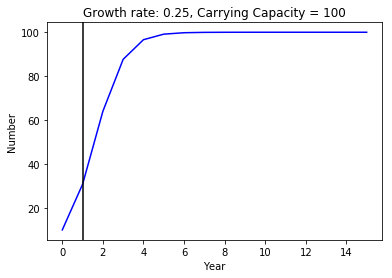

In [10]:
import numpy as np
import matplotlib.pyplot as plt

r = rate_of_increase(4,1,1) # growth rate / yr
K = 100 # carrying capacity
t = 15 # number of years
num = np.zeros(t+1)
num[0] = 10
for i in range(t):
    #num[i+1] = num[i]+r*num[i]*(1-num[i]/K)
    num[i+1] = num[i]*K/(num[i] + (K - num[i])*math.exp(-r))
plt.plot(range(t+1),num, 'b')
plt.xlabel('Year')
plt.ylabel('Number')
plt.title('Growth rate: 0.25, Carrying Capacity = 100')
plt.axvline(np.argmax(np.diff(num)),  color = 'k'  )
plt.show()

#rate_of_increase(1.2,1,1), np.argmax(np.diff(num)), num